<a href="https://colab.research.google.com/github/Coming233/WGAN/blob/main/W_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Wasserstein GANs
Reference: https://arxiv.org/pdf/1701.07875.pdf

In [32]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision
! nvidia-smi

Tue Jan 25 08:08:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   1030MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/test/utils")
from colab_save_load import m_save_para
save_path = "/content/gdrive/My Drive/Colab Notebooks/test/model/test_save"

Mounted at /content/gdrive


In [30]:
MODEL_NAME = 'W-GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [9]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [10]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [11]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
        使用卷积网络来作为判别器和生成器的子网络
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_size+condition_size, 784), # 有控制条件，控制条件和cGAN中的设置一样
            nn.LeakyReLU(0.2), # 用LeakyReLu有效减少“细胞死亡"的后果
        )
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),   # (1, 28, 28)-->(512, 14, 14)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),  # (512, 14, 14)-->(256, 7, 7)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),  # (256, 7, 7)-->(128, 4, 4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
        )
    
    def forward(self, x, c=None):
        # x: (N, 1, 28, 28), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 794)
        y_ = self.transform(v) # (N, 784)
        y_ = y_.view(y_.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        y_ = self.conv(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [12]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        # x: (N, 100), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fc(v)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [13]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [15]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [16]:
batch_size = 64

In [17]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [18]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=0.0005)   # 优化方法用RMSprop
G_opt = torch.optim.RMSprop(G.parameters(), lr=0.0005)

In [19]:
max_epoch = 50 # need more than 100 epochs for training generator
step = 0
g_step = 0
n_noise = 100

In [20]:
def n_critic(step, nc=2):
    if step < 25 or step % 500 == 0:
        return 100
    return nc

In [21]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [22]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [23]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
                   
        # Training Discriminator
        x = images.to(DEVICE) # 数据送入GPU
        y = labels.view(batch_size, 1) # 标签
        y = to_onehot(y).to(DEVICE) # 编码
        x_outputs = D(x, y) # 送入判别器训练

        z = torch.randn(batch_size, n_noise).to(DEVICE) # 生成（N，100）的噪声
        z_outputs = D(G(z, y), y) # 送入生成器的数据进去判别器训练
        D_x_loss = torch.mean(x_outputs) # 输出取平均
        D_z_loss = torch.mean(z_outputs) # 输出取平均
        D_loss = D_z_loss - D_x_loss    # loss = 平均值（生成得到的loss - 真实样本得到的loss）
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():    # 利用夹断模式将判别器的参数限制，限制判别器的能力
            p.data.clamp_(-0.01, 0.01)
                    
        if step % 1 == 0:
            g_step += 1
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = -torch.mean(z_outputs) 

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 0.00549355149269104, G Loss: -0.009972832165658474
Epoch: 0/50, Step: 500, D Loss: -0.0028014453127980232, G Loss: -0.008140716701745987
Epoch: 1/50, Step: 1000, D Loss: -0.002820483408868313, G Loss: -0.00804285891354084
Epoch: 1/50, Step: 1500, D Loss: -0.002930736169219017, G Loss: -0.008022258058190346
Epoch: 2/50, Step: 2000, D Loss: -0.0029772529378533363, G Loss: -0.007986873388290405
Epoch: 2/50, Step: 2500, D Loss: -0.00298211257904768, G Loss: -0.007993416860699654
Epoch: 3/50, Step: 3000, D Loss: -0.000141877681016922, G Loss: -0.008810503408312798
Epoch: 3/50, Step: 3500, D Loss: 3.953464329242706e-05, G Loss: -0.009551387280225754
Epoch: 4/50, Step: 4000, D Loss: 3.203749656677246e-07, G Loss: -0.009553409181535244
Epoch: 4/50, Step: 4500, D Loss: 3.110617399215698e-07, G Loss: -0.009383452124893665
Epoch: 5/50, Step: 5000, D Loss: -3.6600977182388306e-07, G Loss: -0.009359108284115791
Epoch: 5/50, Step: 5500, D Loss: -3.5390257835388184e-07, 

## Sample

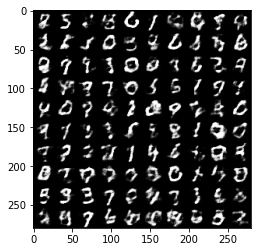

In [24]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [25]:
m_save_para(D.state_dict(), save_path, 'D_WGAN.pkl')
m_save_para(G.state_dict(), save_path, 'G_WGAN.pkl')

In [26]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [27]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
# save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_w.pth.tar')
# save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_w.pth.tar')